In [33]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [19]:
# Load Dataset
df = pd.read_csv("graduation_rate.csv")

# Tampilkan 5 data pertama
df.head()

,ACT composite score,SAT total score,parental level of education,parental income,high school gpa,college gpa,years to graduate
0,22,1625,high school,40999,3.0,3.1,7
1,29,2090,associate's degree,75817,4.0,3.4,5
2,30,2188,bachelor's degree,82888,4.0,3.9,3
3,33,2151,associate's degree,93518,4.0,3.7,5
4,29,2050,associate's degree,79153,4.0,3.4,6


In [20]:
# ===== Tambahkan Label Graduated (berdasarkan college GPA & years to graduate) =====
df['graduated'] = df.apply(
    lambda row: 'yes' if row['college gpa'] >= 2.5 and row['years to graduate'] <= 6 else 'no',
    axis=1
)

In [21]:
# ===== Buat Label Parenting Behavior =====
def infer_parenting_behavior(row):
    if row['parental level of education'] in ['graduate degree', "bachelor's degree"]:
        if row['high school gpa'] >= 3.5:
            return 'authoritative'
        else:
            return 'authoritarian'
    else:
        if row['high school gpa'] >= 3.0:
            return 'permissive'
        else:
            return 'neglectful'

df['parenting_behavior'] = df.apply(infer_parenting_behavior, axis=1)


In [22]:
# 3. Cek Informasi dan Membersihkan Data

# Lihat info kolom
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ACT composite score          1000 non-null   int64  
 1   SAT total score              1000 non-null   int64  
 2   parental level of education  1000 non-null   object 
 3   parental income              1000 non-null   int64  
 4   high school gpa              1000 non-null   float64
 5   college gpa                  1000 non-null   float64
 6   years to graduate            1000 non-null   int64  
 7   graduated                    1000 non-null   object 
 8   parenting_behavior           1000 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 70.4+ KB
None


In [23]:
# Cek missing value
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
ACT composite score            0
SAT total score                0
parental level of education    0
parental income                0
high school gpa                0
college gpa                    0
years to graduate              0
graduated                      0
parenting_behavior             0
dtype: int64


In [24]:
# Drop duplikat jika ada
df = df.drop_duplicates()

In [25]:
# Tambahkan kolom target 'graduated' berdasarkan waktu kelulusan
df['graduated'] = df['years to graduate'].apply(lambda x: 1 if x <= 4 else 0)

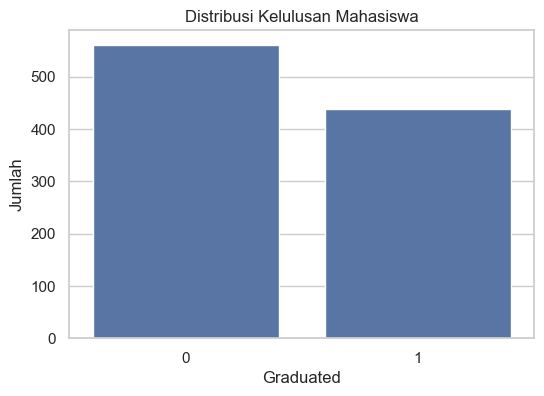

In [26]:
# ===== EDA Graduated =====
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='graduated')
plt.title("Distribusi Kelulusan Mahasiswa")
plt.xlabel("Graduated")
plt.ylabel("Jumlah")
plt.show()

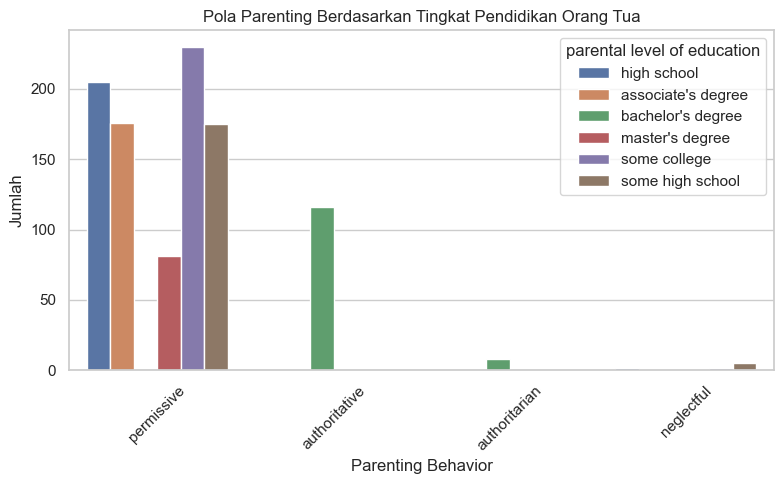

In [27]:
# ===== EDA Parenting vs Pendidikan Orang Tua =====
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='parenting_behavior', hue='parental level of education')
plt.title("Pola Parenting Berdasarkan Tingkat Pendidikan Orang Tua")
plt.xlabel("Parenting Behavior")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Crosstab (proporsi)
crosstab = pd.crosstab(df['parental level of education'], df['parenting_behavior'], normalize='index')
print("Proporsi Parenting Behavior berdasarkan Pendidikan Orang Tua:\n")
print(crosstab)

Proporsi Parenting Behavior berdasarkan Pendidikan Orang Tua:

parenting_behavior           authoritarian  authoritative  neglectful  \
parental level of education                                             
associate's degree                0.000000       0.000000    0.000000   
bachelor's degree                 0.064516       0.935484    0.000000   
high school                       0.000000       0.000000    0.009662   
master's degree                   0.000000       0.000000    0.000000   
some college                      0.000000       0.000000    0.008621   
some high school                  0.000000       0.000000    0.027778   

parenting_behavior           permissive  
parental level of education              
associate's degree             1.000000  
bachelor's degree              0.000000  
high school                    0.990338  
master's degree                1.000000  
some college                   0.991379  
some high school               0.972222  


In [34]:
# ===== Modeling: Prediksi Kelulusan Anak =====

# Encode graduated
df['graduated_encoded'] = LabelEncoder().fit_transform(df['graduated'])  # yes = 1, no = 0

In [35]:
# Fitur prediktor
features = ['ACT composite score', 'SAT total score', 'parental income', 'high school gpa', 'college gpa', 'years to graduate']
X = df[features]
y = df['graduated_encoded']

In [36]:
# Scaling (opsional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
# Model candidates
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

In [39]:
# Train & evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    print(f"\nModel: {name}")
    print(f"Akurasi: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Model: Logistic Regression
Akurasi: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00        80

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Model: Random Forest
Akurasi: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00        80

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Model: KNN
Akurasi: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00        80

   

In [40]:
# Tampilkan model dengan akurasi terbaik
best_model = max(results, key=lambda x: x[1])
print(f"\n🔍 Model terbaik: {best_model[0]} dengan akurasi {best_model[1]:.4f}")


🔍 Model terbaik: Logistic Regression dengan akurasi 1.0000


### Pengaruh Pnedidikan Orang Tua

mengevaluasi pengaruh parental level of education terhadap kelulusan.

In [41]:
# Rata-rata kelulusan per tingkat pendidikan orang tua
df['graduated'] = y  # gabungkan label hasil klasifikasi kembali ke dataframe jika belum

edu_graduation_rate = df.groupby('parental level of education')['graduated'].mean().sort_values(ascending=False)

print("Rata-rata kelulusan berdasarkan tingkat pendidikan orang tua:")
print(edu_graduation_rate)

Rata-rata kelulusan berdasarkan tingkat pendidikan orang tua:
parental level of education
master's degree       0.617284
bachelor's degree     0.500000
associate's degree    0.482955
some college          0.474138
high school           0.376812
some high school      0.300000
Name: graduated, dtype: float64


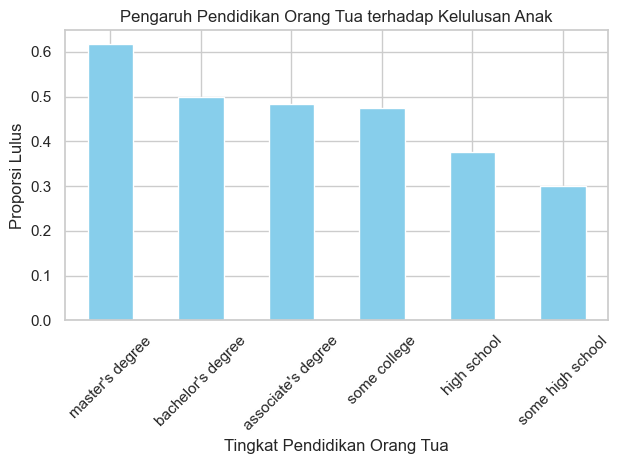

In [42]:
# Visualisasi
edu_graduation_rate.plot(kind='bar', color='skyblue')
plt.title("Pengaruh Pendidikan Orang Tua terhadap Kelulusan Anak")
plt.ylabel("Proporsi Lulus")
plt.xlabel("Tingkat Pendidikan Orang Tua")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 📊 Pengaruh Pendidikan Orang Tua terhadap Kelulusan Anak

### 🔍 Ringkasan

Berdasarkan hasil analisis terhadap dataset yang memuat data pendidikan orang tua dan status kelulusan anak, ditemukan bahwa:

- **Semakin tinggi tingkat pendidikan orang tua, semakin tinggi proporsi kelulusan anak.**
- Anak-anak dengan orang tua lulusan **Master's Degree** memiliki **proporsi kelulusan tertinggi (sekitar 62%)**.
- Sebaliknya, anak dari orang tua dengan pendidikan **Some High School** memiliki **proporsi kelulusan terendah (sekitar 30%)**.

### 📈 Urutan Proporsi Kelulusan (Tertinggi ke Terendah)

1. `Master's degree` – ~62%
2. `Bachelor's degree` – ~50%
3. `Associate's degree` – ~48%
4. `Some college` – ~47%
5. `High school` – ~38%
6. `Some high school` – ~30%

### 🧠 Interpretasi

- **Faktor pendidikan orang tua berpotensi besar memengaruhi pola dukungan akademik, motivasi, dan ekspektasi terhadap anak.**
- Pendidikan lebih tinggi pada orang tua kemungkinan meningkatkan keterlibatan aktif dalam pembelajaran anak dan pemahaman pentingnya pendidikan lanjutan.

### 📌 Kesimpulan

Tingkat pendidikan orang tua merupakan salah satu indikator penting dalam memprediksi kelulusan anak. Kebijakan pendidikan dan program parenting dapat menargetkan intervensi tambahan pada keluarga dengan latar belakang pendidikan rendah untuk meningkatkan outcome anak.